In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import log
import pandas.tseries
#from pandas import Series
#from pandas.core import tseries
from statsmodels.tsa.stattools import adfuller
#from pandas.core import datetools



import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


## (1) Stationarity

- Data points are often __non-stationary__ or have means, variances and covariances that _change over time_. 

- Non-stationary behaviors can be trends, cycles, random walks or combinations of the three.

- Non-stationary data, as a rule, are _unpredictable and cannot be modeled or forecasted._ The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. 

- In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data.


- A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. 

> - constant mean
> - constant variance
> - an autocovariance that does not depend on time.

- Though stationarity assumption is taken in many TS models, almost __none of practical time series are stationary.__

- Most of the TS models work on the _assumption that the TS is stationary._ 

- Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 


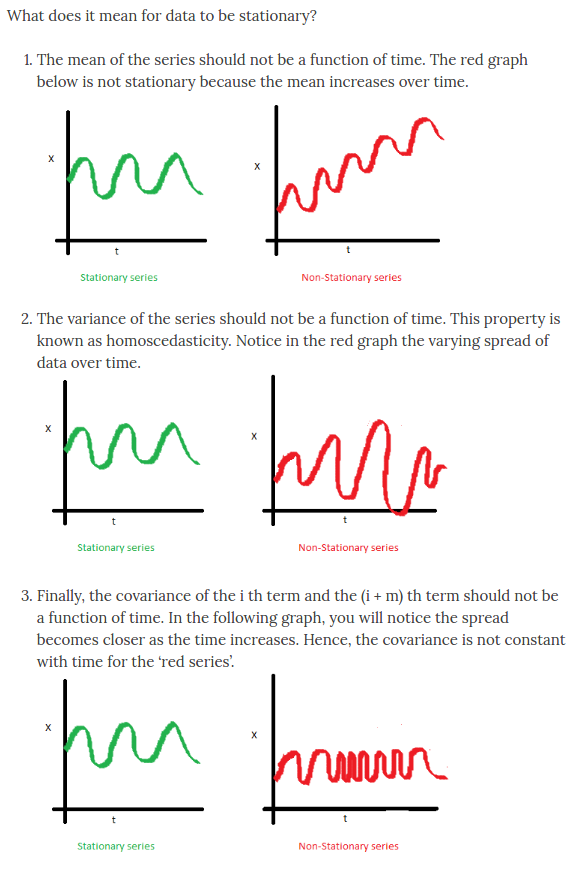

#### Why do we care about stationarity? 

- A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

- Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

> "For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables." 

- With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary. 

#### reading data (air passenders data)

The data contains a particular month and number of passengers travelling in that month.

In [3]:
location = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\AirPassengers.csv'

In [4]:
df_airpassengers = pd.read_csv(location)

print (df_airpassengers.head())
print ('\n Data Types:')
print (df_airpassengers.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

data = pd.read_csv(location, 
                   parse_dates=['Month'], 
                   index_col='Month', 
                   date_parser=dateparse)

print (data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Let’s understand the arguments one by one:

__parse_dates__: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.

__index_col__: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.

__date_parser__: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

In [6]:
ts = data['#Passengers'] 
ts.head(5)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

#### check stationarity using the following methods:-

(1) __Rolling Plots__: review a time series plot ( moving average or moving variance) of the data and visually check if there are any obvious trends or seasonality.

(2) __Summary Statistics__: review the summary statistics for the data for seasons or random partitions and check for obvious or significant differences.

(3) __Statistical Tests__: use statistical tests to check if the expectations of stationarity are met or have been violated.

> __Dickey-Fuller Test__: This is one of the statistical tests for checking stationarity. 

> Here the null hypothesis is that the TS is non-stationary. 

> The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 

> If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

#### Python check ... demo

Moving Averages In pandas

In [7]:
# Create data
data = {'score': [1,1,1,2,2,2,3,3,3]}

# Create dataframe
df = pd.DataFrame(data)

# View dataframe
score_ts = df.score
score_ts

0    1
1    1
2    1
3    2
4    2
5    2
6    3
7    3
8    3
Name: score, dtype: int64

In [8]:
type(score_ts)

pandas.core.series.Series

In [9]:
# deprecated 
# pd.rolling_mean(df.score, window=2)

In [10]:
# deprecated
# pd.rolling_std(df.score, window=2)

In [11]:
# Calculate the moving average. 
# That is, take the first two values, 
# average them, then drop the first and add the third, etc.
# [1,1,1,2,2,2,3,3,3]
score_ts.rolling(window=2).mean()

0    NaN
1    1.0
2    1.0
3    1.5
4    2.0
5    2.0
6    2.5
7    3.0
8    3.0
Name: score, dtype: float64

In [12]:
score_ts.rolling(window=2).median()

0    NaN
1    1.0
2    1.0
3    1.5
4    2.0
5    2.0
6    2.5
7    3.0
8    3.0
Name: score, dtype: float64

... back to main code

#### Stationarity test : Method 1 : Plots 

- stationarity check with baby birth dataset
    - Daily total female births in California, 1959
    - dataset is stationary

In [7]:
location1 = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\daily-total-female-births-in-cal.csv'

In [8]:
series_birth_cal = pd.Series.from_csv(location1, header=0)
series_birth_cal.head()


D:\Anaconda3\lib\site-packages\pandas\core\series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: birth_count, dtype: int64

In [9]:
series_birth_cal.describe()

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: birth_count, dtype: float64

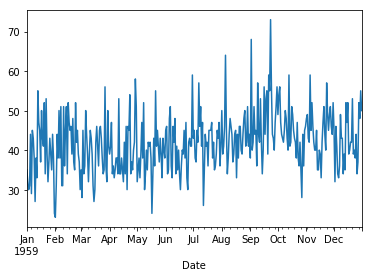

In [10]:
series_birth_cal.plot();

#### Non-Stationary Time Series
Observations from a non-stationary time series show _seasonal effects, trends and other structures_ that depend on the time index.

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

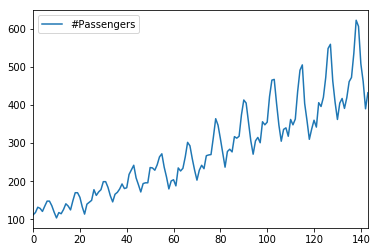

In [11]:
df_airpassengers.plot();

- there is an overall increasing trend in the data along with some seasonal variations.

-  However, it might not always be possible to make such visual inferences 

#### Stationarity test : Method 2 : Summary Statistics

- on cal birth data

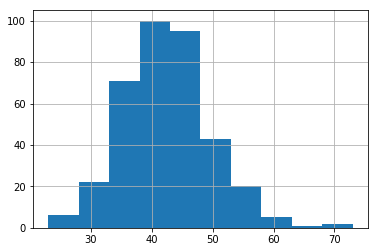

In [12]:
series_birth_cal.hist();

- split the time series into 2 contiguous sequences. 

- calculate the mean and variance of each group of numbers and compare the values.

In [13]:
X = series_birth_cal.values

In [14]:
split = len(X) / 2
split = int(split)
split

182

In [15]:
X1, X2 = X[0:split], X[split:]

In [16]:
mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     =      39.76, mean2     =      44.19
variance1 =      49.21, variance2 =      48.71


- the mean and variance values are different, but in the same ball-park.

In [17]:
X = df_airpassengers['#Passengers'].values

In [18]:
split = len(X) / 2
split = int(split)
split

72

In [19]:
X1, X2 = X[0:split], X[split:]

In [19]:
mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     =      39.76, mean2     =      44.19
variance1 =      49.21, variance2 =      48.71


the mean and variance look very different.

We have a __non-stationary time series.__

- plotting the values of the time series as a histogram.

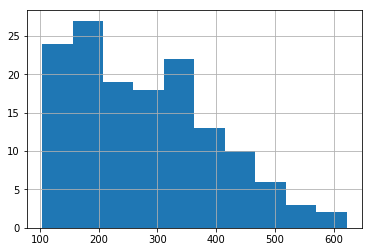

In [20]:
df_airpassengers['#Passengers'].hist();

Reviewing the plot of the time series again, we can see that there is an obvious seasonality component, and it looks like the seasonality component is growing.

This may suggest an exponential growth from season to season. A __log transform__ can be used to flatten out exponential change back to a linear relationship.

In [21]:
X = df_airpassengers['#Passengers'].values
X = log(X)

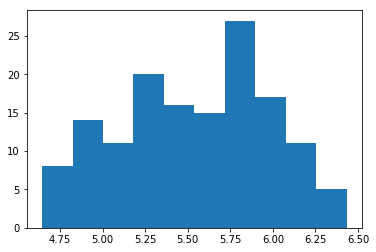

In [22]:
plt.hist(X);

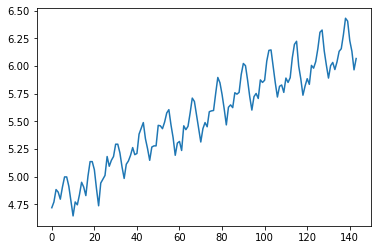

In [24]:
plt.plot(X);

- calculate the mean and standard deviation of the values of the log transformed dataset

In [23]:
X = df_airpassengers['#Passengers'].values
X = log(X)

split = int(len(X) / 2)

X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5.175146, mean2=5.909206
variance1=0.068375, variance2=0.049264


- mean and standard deviation values for each group that are again similar

This is a quick and dirty method that may be misleading.

We can __use a statistical test__ to check if the difference between two samples of Gaussian random variables is real or a statistical fluke. 

We could explore statistical significance tests, like the Student _t-test_

#### Stationarity test : Method 3 : Augmented Dickey-Fuller test - (ADF) test 

- The intuition behind the test is that it determines how strongly a time series is defined by a trend. (i.e no stationarity)

$ H_0 : $ - time series is __not stationary __

$ H_A : $ - time series is stationary 

p-value <= 0.05: Reject the null hypothesis ($H_0$), the data does not have a unit root and is stationary.

> p-value > 0.05: Fail to reject the null hypothesis ($H_0$), the data has a unit root and is non-stationary.

** Returns **

    adf -     Test statistic

    pvalue - MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

#### 3.1. on california baby birth dataset

In [24]:
X = series_birth_cal.values

result = adfuller(X)
result

(-4.808291253559767,
 5.243412990149787e-05,
 6,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 2343.8290926464197)

In [25]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%5s: %8.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	   1%:   -3.449
	   5%:   -2.870
	  10%:   -2.571


#### conclusion

1. p-value method : p-value of 0.000052 is $\lt$ 0.05 so we reject the null hypothesis
    
2. Critical value  : our statistic value of -4 is less than the value of -3.449 at 1%. So this falls in the critical region. Hence we can reject the null hypothesis. i.e TS is stationary

#### 3.2. on air passenger dataset

In [26]:
X = df_airpassengers['#Passengers'].values

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### conclusion

1. p-value method : p-value of 0.991880 is $\gt$ 0.05 so we CANNOT reject the null hypothesis. TS not stationary
    
2. Critical value  : our statistic value of 0.815369 is more than the value of -3.449 at 1%. So this falls in the acceptance region. Hence we CANNOT reject the null hypothesis. i.e TS is not stationary

#### 3.3. on air passenger dataset (log transform)

In [27]:
X = df_airpassengers['#Passengers'].values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.717017
p-value: 0.422367
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### conclusion

1. p-value method : p-value of 0.422367 is $\gt$ 0.05 so we CANNOT reject the null hypothesis. TS not stationary
    
2. Critical value  : our statistic value of 0.422367 is more than the value of -3.449 at 1%. So this falls in the acceptance region. Hence we CANNOT reject the null hypothesis. i.e TS is not stationary

#### 3.4. on air passenger dataset (another example)

In [30]:
X = df_airpassengers['#Passengers']

In [31]:
# Determing rolling statistics
rollin_mean = X.rolling(window=12).mean()
rollin_std  = X.rolling(window=12).std()

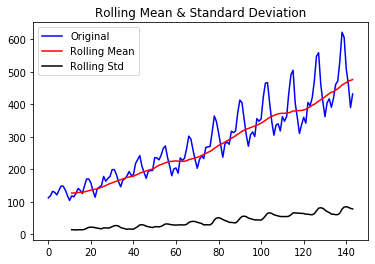

In [32]:
# Plot rolling statistics:
orig = plt.plot(X, color='blue',label='Original')
mean = plt.plot(rollin_mean, color='red', label='Rolling Mean')
std  = plt.plot(rollin_std, color='black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [33]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(X, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### Observation
- the variation in __standard deviation__ is small,
- __mean__ is clearly increasing with time and this is not a stationary series. 

- the __test statistic__ is way more than the critical values. 

#### conclusion

1. p-value method : p-value of 0.991880 is $\gt$ 0.05 so we CANNOT reject the null hypothesis. TS not stationary
    
2. Critical value  : our statistic value of 0.815369 is more than the value of -3.449 at 1%. So this falls in the acceptance region. Hence we CANNOT reject the null hypothesis. i.e TS is not stationary

### How to make a Time Series Stationary?

- its almost impossible to make a series perfectly stationary

- Lets understand what is making a TS non-stationary. 

There are 2 major reasons behind non-stationarity of a TS: 

1. Trend – varying mean over time. 

2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

_The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series._

__reduce trend__ can be transformation. 

For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc



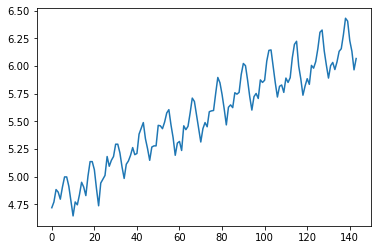

In [34]:
ts_log = np.log(X)
plt.plot(ts_log);

In [35]:
type(ts_log)

pandas.core.series.Series

### Reduce noise

- Smoothing – taking rolling averages (Moving average)

- Differencing

- Polynomial Fitting – fit a regression model
    - Do a LOESS smoothing (Localized Regression)
    - Do a LOWESS smoothing (Locally Weighted Regression)
    
- Aggregation – taking average for a time period like monthly/weekly averages

#### 1. Smoothing - Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

In [36]:
moving_avg = ts_log.rolling(window=12).mean()

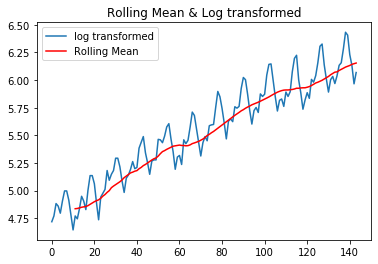

In [37]:
plt.plot(ts_log, label='log transformed')
plt.plot(moving_avg, color='red', label='Rolling Mean');

plt.legend(loc='best')
plt.title('Rolling Mean & Log transformed');

Lets the __rolling means__ subtract this from the original series(log transformed). 

Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. 

In [38]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11   -0.065494
Name: #Passengers, dtype: float64

Lets drop these NaN values and check the plots to test stationarity.

In [39]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rollin_mean = timeseries.rolling(window=12).mean()
    rollin_std  = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics:
    orig = plt.plot(timeseries,  color='blue',  label='Original')
    mean = plt.plot(rollin_mean, color='red',   label='Rolling Mean')
    std  = plt.plot(rollin_std,  color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)

In [39]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

NameError: name 'test_stationarity' is not defined

#### observation

- The rolling values appear to be varying slightly but there is no specific trend. 
- Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a __stationary series.__

#### conclusion

1. p-value method : p-value of 0.022235 is $\lt$ 0.05 so we REJECT the null hypothesis. TS is stationary
    
2. Critical value  : our statistic value of -3.162908 is more than the value of -2.886151 at 5%. So this falls in the rejection region. Hence we REJECT the null hypothesis. i.e TS is stationary


> a __drawback__ in this particular approach is that the time-period has to be strictly defined. In this case we took yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a __‘weighted moving average’__ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is __exponentially weighted moving average__ where weights are assigned to all the previous values with a decay factor.

#### 2. exponentially weighted moving average

- sample example

In [47]:
ewma = pd.Series.ewm

x  = np.linspace(0, 2 * np.pi, 100)
y  = 2 * np.sin(x) + 0.1 * np.random.normal(x)

df = pd.Series(y)

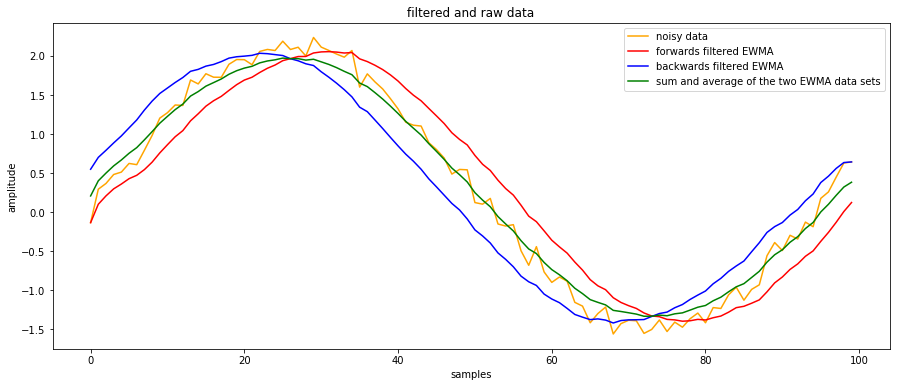

In [48]:
# take EWMA in both directions then average them
fwd = ewma(df, span=10).mean()           # take EWMA in fwd direction
bwd = ewma(df[::-1], span=10).mean()     # take EWMA in bwd direction
filtered = np.vstack(( fwd, bwd[::-1] )) # lump fwd and bwd together
filtered = np.mean(filtered, axis=0 )    # average

plt.title('filtered and raw data')

plt.plot(y,        color = 'orange', label = 'noisy data')
plt.plot(fwd,      color = 'red',    label = 'forwards filtered EWMA ')
plt.plot(bwd,      color = 'blue',   label = 'backwards filtered EWMA')
plt.plot(filtered, color = 'green',  label = 'sum and average of the two EWMA data sets')

plt.xlabel('samples')
plt.ylabel('amplitude')
plt.legend(loc='best');

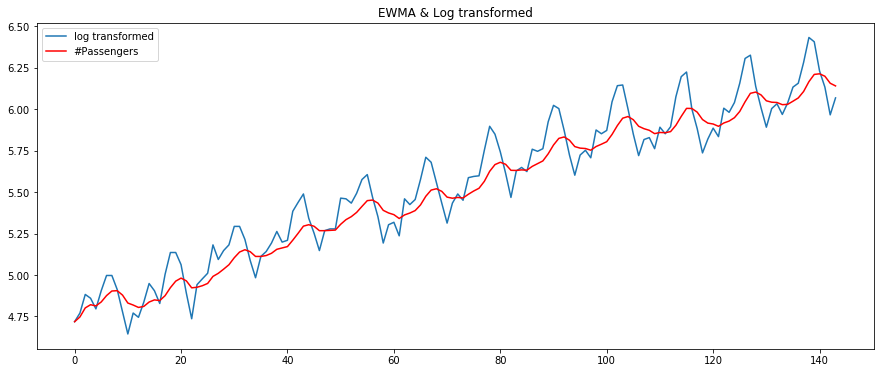

In [52]:
ewma = pd.Series.ewm

fwd_expwighted_avg = ewma(ts_log, span=10).mean() 

plt.plot(ts_log, label='log transformed')
plt.plot(fwd_expwighted_avg, color='red');

plt.legend(loc='best')
plt.title('EWMA & Log transformed');

#### Now, let’s remove this from series and check stationarity:

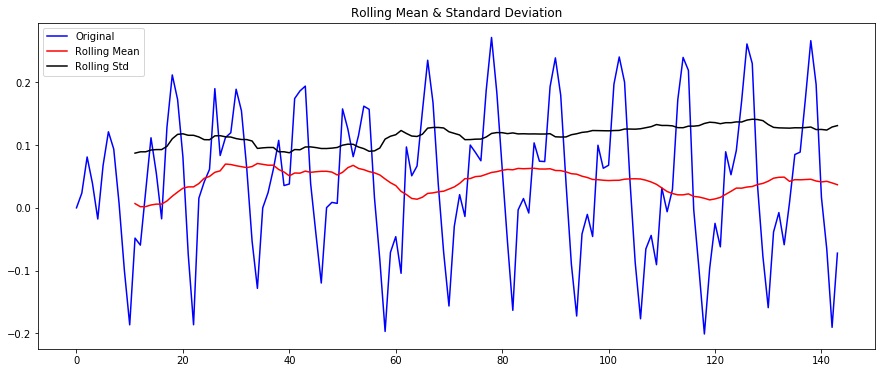

Results of Dickey-Fuller Test:
Test Statistic                  -3.245609
p-value                          0.017492
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [53]:
ts_log_ewma_diff = ts_log - fwd_expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case.

#### 3. Differencing

- One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 

- This mostly works well in improving __stationarity.__

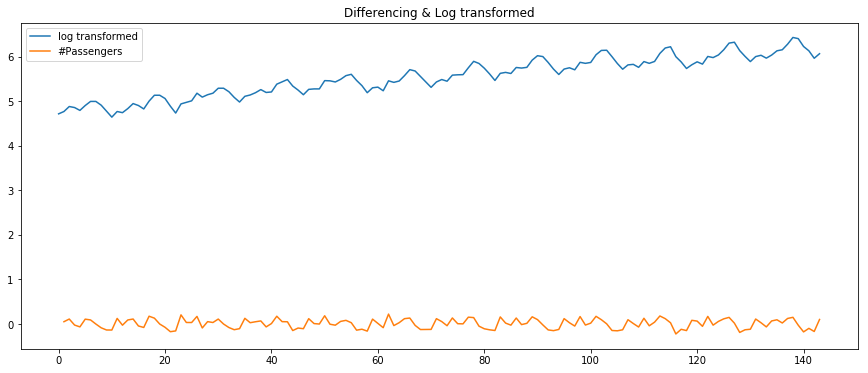

In [54]:
ts_log_diff = ts_log - ts_log.shift()

plt.plot(ts_log, label='log transformed')
plt.plot(ts_log_diff);

plt.legend(loc='best')
plt.title('Differencing & Log transformed');


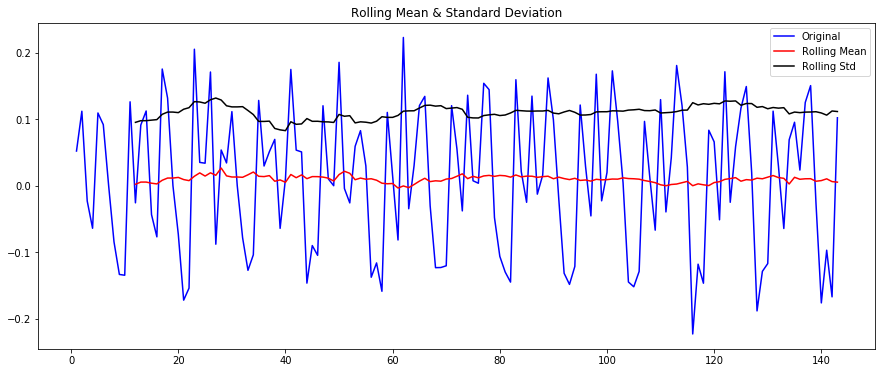

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [155]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence.